## Exploring Rossmann Drug Store Sales Data

In [1]:
import pandas as pd

data = pd.read_csv('../../assets/dataset/rossmann.csv', 
                   skipinitialspace=True, 
                   low_memory=False)

Because we are most interested in the `Date` column that contains the date of sales for each store, we will make sure to process that as a `DateTime` type, and make that the index of our dataframe.

In [2]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

data['Year'] = data.index.year
data['Month'] = data.index.month

In [3]:
store1_data = data[data.Store == 1]

### Data Exploration and MINEing

To compare sales on holidays, we can compare the sales using box-plots, which allows us to compare the distribution of sales on holidays against all other days.  On state holidays, the store is closed (and as a nice sanity check there are 0 sales), and on school holidays the sales are relatively similar.

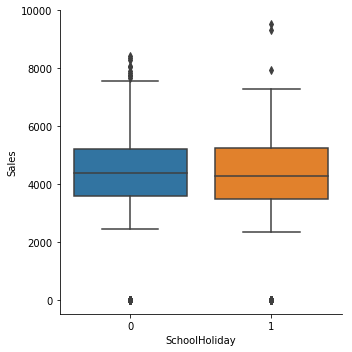

In [5]:
import seaborn as sb
%matplotlib inline

sb.catplot(
    x='SchoolHoliday',
    y='Sales',
    data=store1_data, 
    kind='box'
)

> Check: See if there is a difference affecting sales on promotion days.

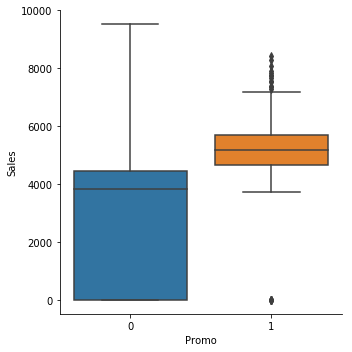

In [7]:
# TODO
sb.catplot(
    x='Promo',
    y='Sales',
    data=store1_data, 
    kind='box'
)

Lastly, we want to identify larger-scale trends in our data. How did sales change from 2014 to 2015? Were there any particularly interesting outliers in terms of sales or customer visits?

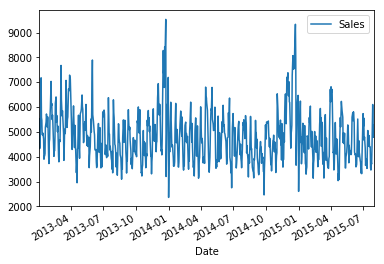

In [8]:
# Filter to days store 1 was open
store1_open_data = store1_data[store1_data.Open==1]
store1_open_data[['Sales']].plot()

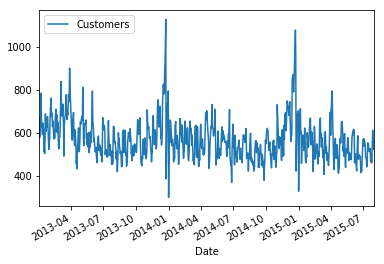

In [9]:
store1_open_data[['Customers']].plot()

In pandas, we can compute rolling average using the `pd.rolling_mean` or `pd.rolling_median` functions.

### Data REFINING Using Time Series Statistics

### Autocorrelation

To measure how much the sales are correlated with each other, we want to compute the _autocorrelation_ of the 'Sales' column. In pandas, we do this we with the `autocorr` function:

`autocorr` takes one argument, the `lag` which is how many prio data points should be used to compute the correlation. If we set the `lag` to 1, we compute the correlation between every point and the point directly preceding it. Setting `lag` to 10 computes the correlation between every point and the point 10 days earlier.

In [10]:
data['Sales'].resample('D').mean().autocorr(lag=7)

0.5574893588739607

### Rolling Averages

If we want to investigate trends over time in sales, as always, we will start by computing simple aggregates.  What were the mean and median sales for each month and year?

In Pandas, this is performed using the `resample` command, which is very similar to the `groupby` command. It allows us to group over different time intervals.

We can use `data.resample` and provide as arguments:
    - The level on which to roll-up to, 'D' for day, 'W' for week, 'M' for month, 'A' for year
    - What aggregation to perform: 'mean', 'median', 'sum', etc.

In [11]:
data[['Sales']].resample('W').median().head()

Sales
Date             
2013-01-06   4229
2013-01-13   6408
2013-01-20   4418
2013-01-27   6019
2013-02-03   4870

In [12]:
data[['Sales']].resample('W').mean().head()

Sales
Date                   
2013-01-06  3906.314098
2013-01-13  6313.289174
2013-01-20  4404.582319
2013-01-27  5898.804484
2013-02-03  4928.382960

While identifying the monthly averages is useful, we often want to compare the sales data of a date to a smaller window. To understand holidays sales, we don't want to compare late December with the entire month, but perhaps with a few days surrounding it. We can do this using rolling averages.

In pandas, we can compute rolling average using the `df.rolling().mean()` or `df.rolling().median()` functions.

In [13]:
data['Sales'].rolling(window=3, center=True).mean().head()

Date
2015-07-31            NaN
2015-07-31    6547.000000
2015-07-31    9457.666667
2015-07-31    9043.666667
2015-07-31    8156.000000
Name: Sales, dtype: float64

In [14]:
store1_data['Sales'].resample('D').mean().rolling(window=3, center=True).mean().head()

Date
2013-01-01            NaN
2013-01-02    3285.666667
2013-01-03    4781.000000
2013-01-04    4603.333333
2013-01-05    3161.000000
Freq: D, Name: Sales, dtype: float64

`rolling().mean()` (as well as `rolling().median()`) takes these important parameters:
    - the first is the series to aggregate
    - `freq` is on what level to roll-up the averages to (as used in `resample`). Either `D` for day, `M` for month or `A` for year, etc.
    - `window` is the number of days to include in the average
    - `center` is whether the window should be centered on the date or use data prior to that date
   

Instead of plotting the full timeseries, we can plot the rolling mean instead, which smooths random changes in sales as well as removing outliers, helping us identify larger trends.

In [19]:
# store1_data[['Sales']].rolling(freq= 'D', window=10, center=True).mean().plot()

### Pandas Window functions
Pandas `rolling().mean()` and `rolling().median()` are only two examples of Pandas window function capabilities. Window functions are operate on a set of N consecutive rows (a window) and produce an output.

In addition to `rolling().mean()` and `rolling().median()`, there are `rollin().sum()`, `rolling().min()`, `rolling().max()`... and many more.

Another common one is `diff`, which takes the difference over time. `pd.diff` takes one arugment, `periods`, which is how many rows prior to use for the difference.


In [20]:
data['Sales'].diff(periods=1).head()

Date
2015-07-31       NaN
2015-07-31     801.0
2015-07-31    2250.0
2015-07-31    5681.0
2015-07-31   -9173.0
Name: Sales, dtype: float64

### Pandas expanding functions

In addition to the set of `rolling_*` functions, Pandas also provides a similar collection of `expanding_*` functions, which, instead of using a window of N values, use all values up until that time.

In [21]:
# computes the average sales, from the first date _until_ the date specified.
store1_data['Sales'].resample('D').mean().expanding(min_periods=1).mean().head()

Date
2013-01-01       0.000000
2013-01-02    2765.000000
2013-01-03    3285.666667
2013-01-04    3585.750000
2013-01-05    3868.000000
Freq: D, Name: Sales, dtype: float64

## Exercises

> Plot the distribution of sales by month and compare the effect of promotions

In [16]:
# sb.factorplot(
#     hue='Promo',
#     x='',
#     y='',
#     data=data, 
#     kind='box'
# )



> Are sales more correlated with the prior date, a similar date last year, or a similar date last month?

In [22]:
average_daily_sales = data[['Sales', 'Open']].resample('D').mean()
#average_daily_sales['Sales'].autocorr(lag=)


> Plot the 15 day rolling mean of customers in the stores

In [23]:
#first sum up all the stores by day
all_stores = data[['Sales', 'Customers']].resample('D').sum()
all_stores.head()

Sales  Customers
Date                          
2013-01-01    97235      19491
2013-01-02  6949829     834075
2013-01-03  6347820     761040
2013-01-04  6638954     782137
2013-01-05  5951593     687472

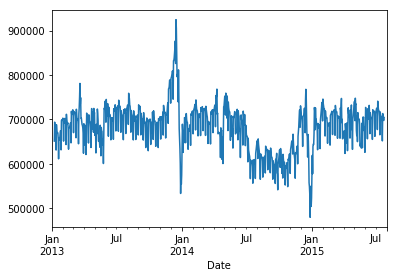

In [19]:
all_stores['Customers'].rolling(freq='D', window=15, center=True).mean().plot()



> Identify the date with largest drop in sales from the same date in the previous month

In [20]:
#resample for average daily sales Keep ('Sales', 'Open')
#all_stores['Sales'].diff(periods=).head()


> Compute the total sales up until Dec. 2014

In [21]:
#all_stores.expanding().sum()[YYYY-MM-DD]


> When were the largest differences between 15-day moving/rolling averages?
> HINT: Using `rolling().mean()` and `diff`